In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl  
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt, find_peaks
import scipy.stats as stats
from matplotlib.pyplot import cm
import ephem
import scipy.special as scp
import sys
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

import utilities as uti
import corrections as cor
import geometry as geo

from IPython.display import display, Latex
import seaborn as sb
from ldtk import LDPSetCreator, BoxcarFilter

In [35]:
filters = [BoxcarFilter('g', 465, 475),	# Define your passbands
		   BoxcarFilter('b', 370, 380)]	# - Boxcar filters useful in transmission spectroscopy


In [36]:
sc = LDPSetCreator(teff=(5000, 100),    # Define your star, and the code downloads the uncached stellar spectra from the Husser et al.
                   logg=(3.60, 0.10),    # surface gravity log g
                      z=(0.0, 0.05),    # stellar metalicity
                     filters=filters)

In [37]:
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(300)

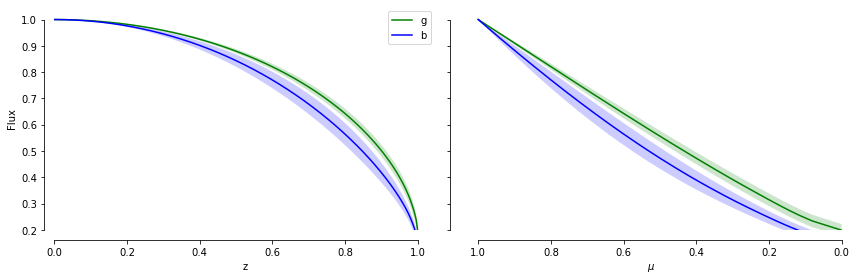

In [54]:
cp = ['green', 'blue']
fig,ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i in range(ps._nfilters):
    ax[0].fill_between(ps._z, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], 
                    facecolor=cp[i], alpha=0.2)
    ax[0].plot(ps._z, ps._mean[i], '-', c=cp[i], label=ps._filters[i])
    ax[1].fill_between(ps._mu, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], 
                    facecolor=cp[i], alpha=0.2)
    ax[1].plot(ps._mu, ps._mean[i], '-', c=cp[i], label=ps._filters[i])
ax[0].legend()
plt.setp(ax[0], xlim=(0,1.05), ylim=(0.2,1.05), xlabel='z', ylabel='Flux')
plt.setp(ax[1], xlim=(1.05,0), ylim=(0.2,1.05), xlabel='$\mu$')
sb.despine(fig, offset=10, trim=True)
plt.setp(ax[1].get_yticklabels(), visible=False)
fig.tight_layout()

In [50]:
'''
cmap = cm.get_cmap("Spectral")
cp = cmap(np.linspace(0.1,1.0,4))
fig,ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i in range(ps._nfilters):
    ax[0].fill_between(ps._z, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], 
                    facecolor=cp[i], alpha=0.2)
    ax[0].plot(ps._z, ps._mean[i], '-', c=cp[i], label=ps._filters[i])
    ax[1].fill_between(ps._mu, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], 
                    facecolor=cp[i], alpha=0.2)
    ax[1].plot(ps._mu, ps._mean[i], '-', c=cp[i], label=ps._filters[i])
ax[0].legend()
plt.setp(ax[0], xlim=(0,1.05), ylim=(0.2,1.05), xlabel='z', ylabel='Flux')
plt.setp(ax[1], xlim=(1.05,0), ylim=(0.2,1.05), xlabel='$\mu$')
sb.despine(fig, offset=10, trim=True)
plt.setp(ax[1].get_yticklabels(), visible=False)
fig.tight_layout()
'''

'\ncmap = cm.get_cmap("Spectral")\ncp = cmap(np.linspace(0.1,1.0,4))\nfig,ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)\nfor i in range(ps._nfilters):\n    ax[0].fill_between(ps._z, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], \n                    facecolor=cp[i], alpha=0.2)\n    ax[0].plot(ps._z, ps._mean[i], \'-\', c=cp[i], label=ps._filters[i])\n    ax[1].fill_between(ps._mu, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], \n                    facecolor=cp[i], alpha=0.2)\n    ax[1].plot(ps._mu, ps._mean[i], \'-\', c=cp[i], label=ps._filters[i])\nax[0].legend()\nplt.setp(ax[0], xlim=(0,1.05), ylim=(0.2,1.05), xlabel=\'z\', ylabel=\'Flux\')\nplt.setp(ax[1], xlim=(1.05,0), ylim=(0.2,1.05), xlabel=\'$\\mu$\')\nsb.despine(fig, offset=10, trim=True)\nplt.setp(ax[1].get_yticklabels(), visible=False)\nfig.tight_layout()\n'

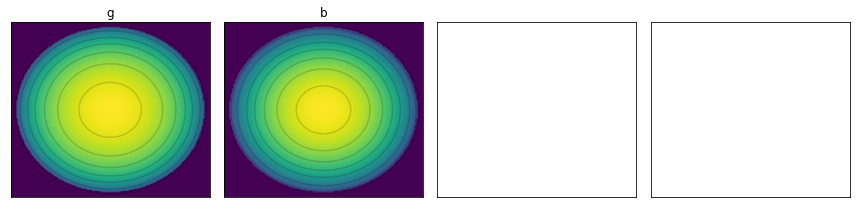

In [55]:
x,y = np.meshgrid(np.linspace(-1.05, 1.05, 150), np.linspace(-1.05, 1.05, 150))
r = np.sqrt(x**2+y**2)

profiles = ps.profile_averages
fig, axs = plt.subplots(1, 4, figsize=(12,3), sharex=True, sharey=True)
for i,ldp in enumerate(profiles):
    axs.flat[i].imshow(np.interp(r, ps._z, ldp, left=0, right=0), 
                       vmin=0, vmax=1, aspect='auto', extent=(-1.05,1.05,-1.05,1.05))
    axs.flat[i].contour(x, y, np.interp(r, ps._z, ldp, left=0, right=0), colors='k', alpha=0.15,
                        levels=[0.0, 0.25, 0.4, 0.55, 0.65, 0.75, 0.85, 0.95, 1])
    axs.flat[i].set_title(ps._filters[i])
plt.setp(axs, xticks=[], yticks=[])
fig.tight_layout()


In [56]:
qc, qe = ps.coeffs_qd()
cu, ce = ps.coeffs_ln()

In [58]:
for i, (c, e) in enumerate(zip(qc, qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))
    
for j, (c, e) in enumerate(zip(cu, ce)):
    display(Latex('u$_{j:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'.format(j=j+1,c=c,e=e)))    
    


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>